# Compare RAGIS ice-sheet wide timeseries to IMBIE

In [1]:
from datetime import datetime
import numpy as np
import pylab as plt
import xarray as xr
from glob import glob
import pandas as pd
import os

import seaborn as sns

from pismragis.observations import load_imbie
from pismragis.analysis import resample_ensemble_by_data
from pismragis.processing import convert_netcdf_to_dataframe, check_file, copy_file
from pismragis.sensitivity import sensitivity_analysis
from pismragis.stats import run_stats

In [2]:
n_jobs = 8
norm_year = 1992.0

mass_varname = f"Contribution to sea-level since {int(norm_year)} (cm SLE)"
flux_varname = "D (Gt/yr)"
bg_color = "#216779"
bg_color = "w"

sim_colors = ["#882255", "#DDCC77", "#AA4499", "#CC6677"]
imbie_color = "#88CCEE"
    
kg2cmsle = 1 / 1e12 * 1.0 / 362.5 / 10.0
gt2cmsle = 1 / 362.5 / 10.0
sigma = 2
plt.style.use('default')

## Load IMBIE

In [3]:
imbie = load_imbie()

glob PISM scalar time series files

In [4]:
data_dir = "../hindcasts"

experiments = []

exp = {
    "Experiment": "frontal melt",
    "proj_dir": "2023_04_ocean_50",
    "scalar_dir": "scalar",
    "processed_dir": "processed",
    "lhs": "gris_ragis_ocean_lhs_50_w_posterior",
}

ens_file = os.path.join(data_dir, exp["proj_dir"], "uq", f"""{exp["lhs"]}.csv""")
s_dir = os.path.join(data_dir, exp["proj_dir"], exp["scalar_dir"])
scalar_files = sorted(glob(os.path.join(s_dir, "ts_gris_g*00m_v20*RAGIS_id_*_1980-1-1_2020-1-1.nc")))
processed_path = os.path.join(data_dir, exp["proj_dir"], exp["processed_dir"])


for scalar_file in scalar_files:
    if check_file(scalar_file):
        copy_file(scalar_file, processed_path)
        
processed_files = sorted(glob(os.path.join(processed_path, "ts_gris_g*00m_v20*RAGIS_id_*_1980-1-1_2020-1-1.nc")))

exp_df = convert_netcdf_to_dataframe(processed_files, resample="yearly", verbose=False, n_jobs=n_jobs)
exp_df["Experiment"] = exp["Experiment"]
exp["data_df"] = exp_df
exp["run_stats"] = run_stats(processed_files)
sa_df = sensitivity_analysis(exp_df.dropna(), ensemble_file=ens_file, n_jobs=n_jobs)
exp["sensitivity_df"] = sa_df
experiments.append(exp)

exp = {
    "Experiment": "ctrl",
    "proj_dir": "2023_04_ocean_simple_50",
    "scalar_dir": "scalar",
    "processed_dir": "processed",
    "lhs": "gris_ragis_ocean_simple_lhs_50_w_posterior",
}

ens_file = os.path.join(data_dir, exp["proj_dir"], "uq", f"""{exp["lhs"]}.csv""")
s_dir = os.path.join(data_dir, exp["proj_dir"], exp["scalar_dir"])
scalar_files = sorted(glob(os.path.join(s_dir, "ts_gris_g*00m_v20*RAGIS_id_*_1980-1-1_2020-1-1.nc")))
processed_path = os.path.join(data_dir, exp["proj_dir"], exp["processed_dir"])


for scalar_file in scalar_files:
    if check_file(scalar_file):
        copy_file(scalar_file, processed_path)
        
processed_files = sorted(glob(os.path.join(processed_path, "ts_gris_g*00m_v20*RAGIS_id_*_1980-1-1_2020-1-1.nc")))

exp_df = convert_netcdf_to_dataframe(processed_files, resample="yearly", verbose=False, n_jobs=n_jobs)
exp_df["Experiment"] = exp["Experiment"]
exp["data_df"] = exp_df
exp["run_stats"] = run_stats(processed_files)
sa_df = sensitivity_analysis(exp_df.dropna(), ensemble_file=ens_file, n_jobs=n_jobs)
exp["sensitivity_df"] = sa_df
experiments.append(exp)

Converting netcdf files to pandas.DataFrame
-------------------------------------------



Processing files: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.32it/s]


Program finished in 5 seconds


Processing file: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:10<00:00,  4.08it/s]


Converting netcdf files to pandas.DataFrame
-------------------------------------------



Processing files: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:03<00:00, 15.25it/s]


Program finished in 3 seconds


Processing file: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:09<00:00,  4.18it/s]


Peformace Summary for Experiment frontal melt
-----------------------------------------------

processor_hours                   44257.904082
wall_clock_hours                    553.223801
model_years_per_processor_hour        0.039829
dtype: float64
Peformace Summary for Experiment ctrl
-----------------------------------------------

processor_hours                   37130.315806
wall_clock_hours                    464.128948
model_years_per_processor_hour        0.052459
dtype: float64


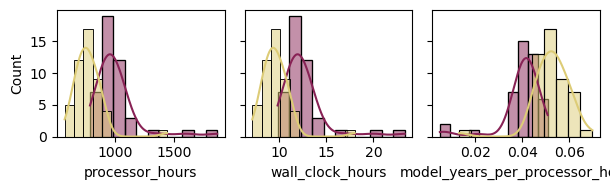

In [5]:
e = experiments[0]["run_stats"]
m_vars = e.columns
fig, axs = plt.subplots(nrows=1, ncols=len(m_vars), sharey="row", figsize=[6.2, 2.0])
fig.subplots_adjust(wspace=0)
for m in range(len(experiments)):
    e_df = experiments[m]["run_stats"]
    print(f"""Peformace Summary for Experiment {experiments[m]["Experiment"]}""")
    print("-----------------------------------------------\n")
    print(e_df.agg({'processor_hours': 'sum', 'wall_clock_hours': "sum", "model_years_per_processor_hour": "mean"}))
    [sns.histplot(data=e_df, x=m_var, bins=11, kde=True, ax=axs[k], color=sim_colors[m]) for k, m_var in enumerate(m_vars)]
fig.tight_layout()
fig.savefig("run_stats.pdf")

## Plot

Plot time series of cumulative mass change (cm SLE) and discharge at grounding line (Gt/yr)

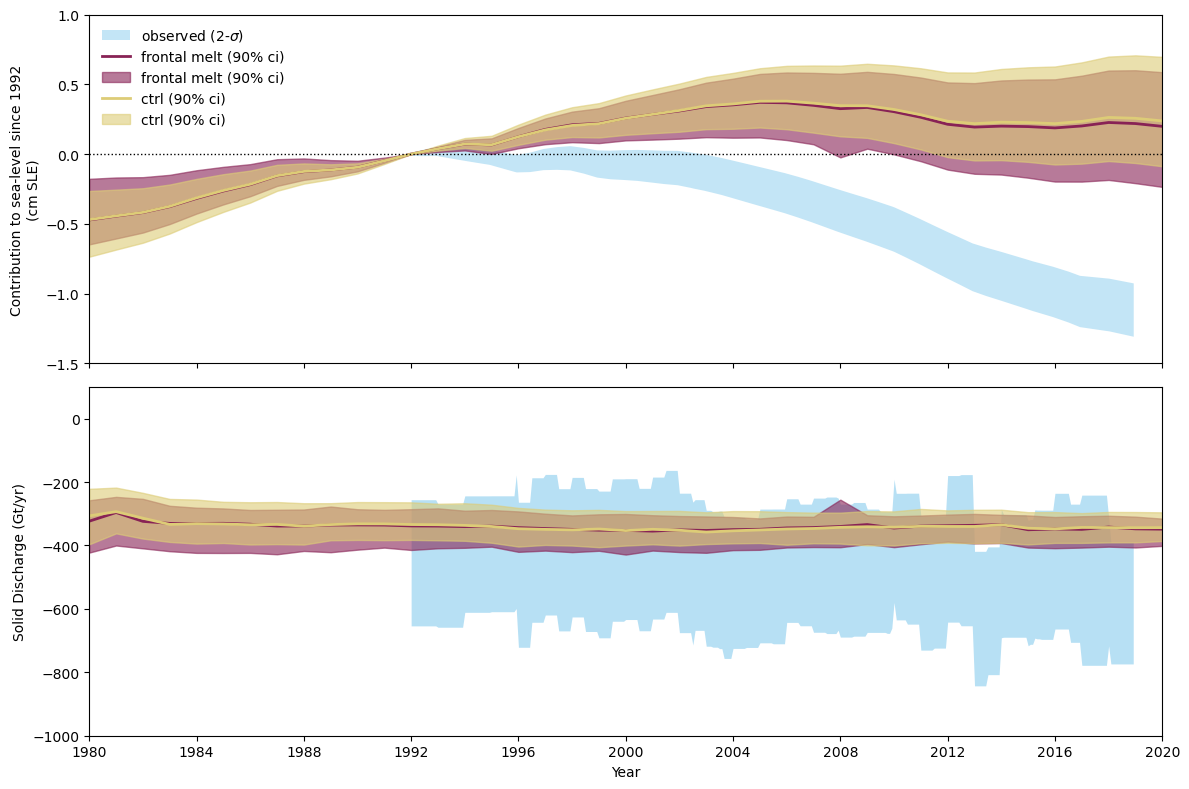

In [6]:
labels = ["frontal melt (90% ci)", "ctrl (90% ci)"]
fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(12, 8))
fig.subplots_adjust(wspace=0.0, hspace=0.0)

axs[0].fill_between(imbie["Date"], 
                    (imbie["Mass (Gt)"] + sigma * imbie["Mass uncertainty (Gt)"]) * gt2cmsle, 
                    (imbie["Mass (Gt)"] - sigma * imbie["Mass uncertainty (Gt)"]) / 362.5 / 10.0, 
                    ls="solid", lw=0, alpha=0.5, color=imbie_color, label="observed (2-$\sigma$)")
axs[1].fill_between(imbie["Date"], 
                    (imbie["D (Gt/yr)"] + sigma * imbie["D uncertainty (Gt/yr)"]), 
                    (imbie["D (Gt/yr)"] - sigma * imbie["D uncertainty (Gt/yr)"]), 
                    ls="solid", lw=0, alpha=0.6, color=imbie_color)

# all_exps = pd.concat([experiments[e]["data_df"] for e in range(len(experiments))]).reset_index(drop=True)
# sns.lineplot(data=all_exps, x="time", y=mass_varname, hue="Experiment", palette=sim_colors[:2], ax=axs[0], estimator="median", ci=None)
# sns.lineplot(data=all_exps, x="time", y=flux_varname, hue="Experiment", palette=sim_colors[:2], ax=axs[1], estimator="median", ci=None)

for k, exp in enumerate(experiments):
    df = exp["data_df"]
    q_05 = df.groupby(by="time").quantile(0.05, numeric_only=True)
    q_50 = df.groupby(by="time").quantile(0.50, numeric_only=True)
    q_95 = df.groupby(by="time").quantile(0.95, numeric_only=True)
    axs[0].plot(q_50.index, q_50[mass_varname], 
                        color=sim_colors[k], alpha=1.0, lw=2, label=labels[k])
    axs[1].plot(q_50.index, q_50[flux_varname], 
                        color=sim_colors[k], alpha=1.0, lw=2)
    axs[0].fill_between(q_05.index, q_05[mass_varname], 
                        q_95[mass_varname], 
                        color=sim_colors[k], alpha=0.6, lw=1, label=labels[k])
    axs[1].fill_between(q_05.index, q_05[flux_varname], 
                        q_95[flux_varname], 
                        color=sim_colors[k], alpha=0.6, lw=1)




fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)

axs[0].axhline(0, color="k", ls="dotted", lw=1.0)
axs[0].set_xlabel("")
axs[0].set_ylabel("Contribution to sea-level since 1992\n(cm SLE)")
axs[1].set_xlabel("Year")
axs[1].set_ylabel("Solid Discharge (Gt/yr)")
axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2020-1-1"))
axs[0].set_ylim(-1.5, 1.0)
axs[1].set_ylim(-1000, 100)
legend = axs[0].legend()
legend.get_frame().set_linewidth(0.0)
legend.get_frame().set_alpha(0.0)
fig.tight_layout()
fig.savefig("ragis-comp_scalar.pdf")


## Plot sensitivity index

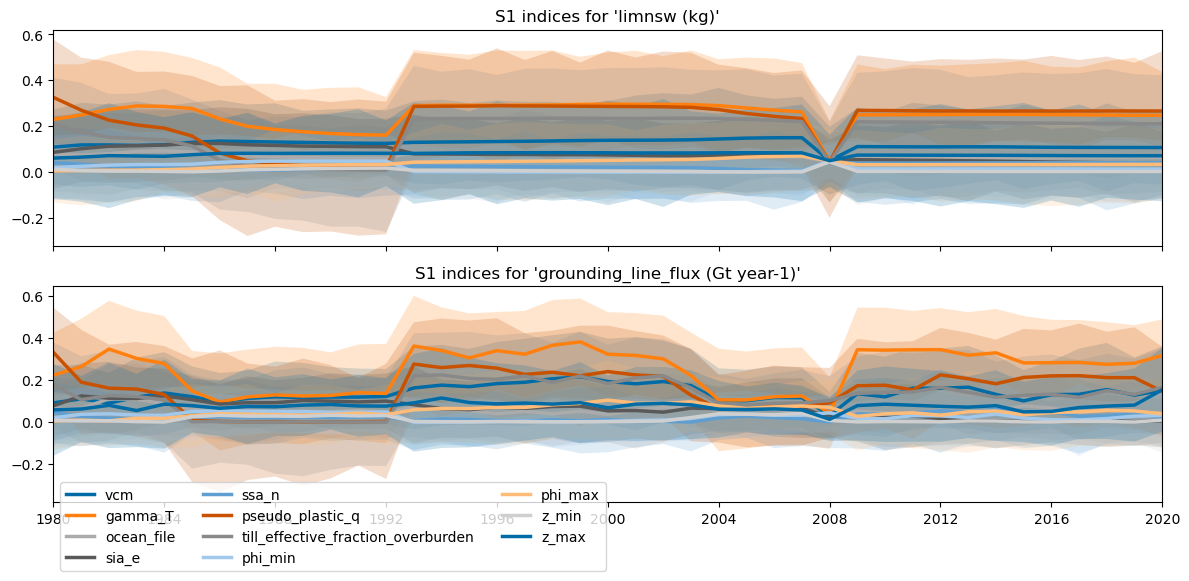

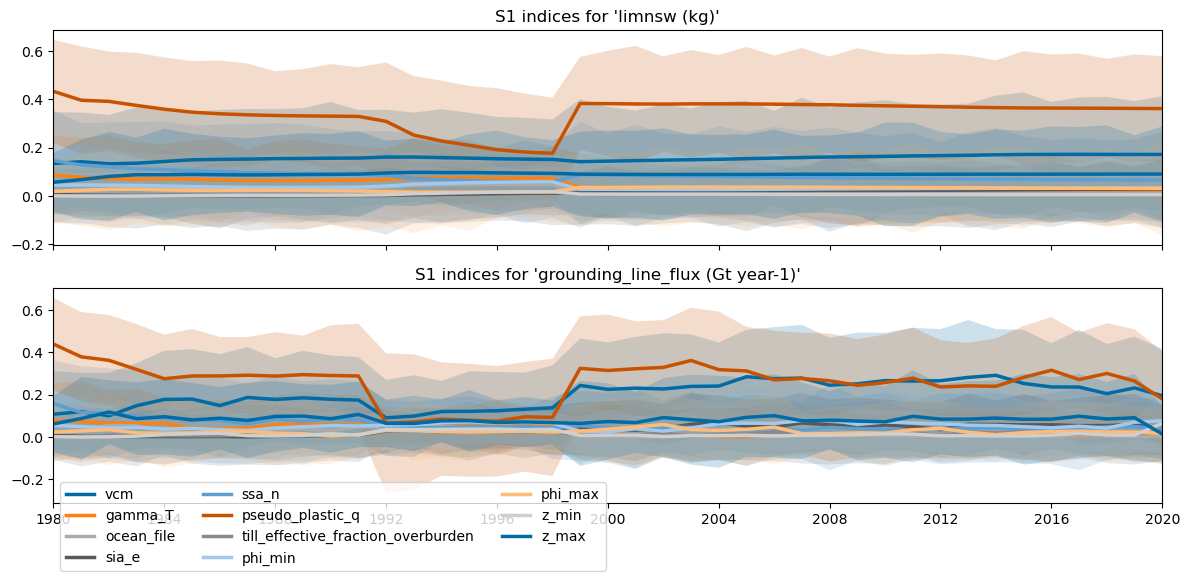

In [7]:
plt.style.use("tableau-colorblind10")

for e, of in zip(experiments, ["ocean", "ocean_simple"]):
    sa_df = e["sensitivity_df"]
    si = "S1"
    outfile = f"""{e["lhs"]}.pdf"""
    fig, axs = plt.subplots(
        2,
        1,
        sharex="col",
        figsize=[12, 6],
    )
    fig.subplots_adjust(bottom=0.0)
    for k, m_var in enumerate(["limnsw (kg)", "grounding_line_flux (Gt year-1)"]):
        m_df = sa_df[sa_df["Variable"] == m_var]
        ax = axs.ravel()[k]
        p_df = m_df[m_df["Si"] == si].drop(columns=["Si", "Variable"]).set_index("Date")
        p_conf_df = m_df[m_df["Si"] == si + "_conf"].drop(columns=["Si"])

        [
            ax.plot(p_df.index, p_df[v], lw=2.5, label=v)
            for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]

        [
            ax.fill_between(
                p_df.index,
                p_df[v].values - p_conf_df[v].values,
                p_df[v].values + p_conf_df[v].values,
                alpha=0.2,
                lw=0,
            )
            for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]
        ax.set_xlim(datetime(1980, 1, 1), datetime(2020, 1, 1))
        lgd = ax.set_title(f"{si} indices for '{m_var}'")
    legend = axs[-1].legend(loc="lower left", ncols=3, bbox_to_anchor=(0, -0.35))
    fig.tight_layout()
    fig.savefig(f"{si}_{outfile}")


In [8]:
ragis_calib = resample_ensemble_by_data(imbie, exp["data_df"], 
                                        fudge_factor=5)
calib_exps = ragis_calib["Experiment"].unique()
print(calib_exps)

/Users/andy/Library/Python/3.10/lib/python/site-packages/pismragis-0.1b0-py3.10.egg/pismragis/analysis.py:258: RuntimeWarning: overflow encountered in exp
  weights = np.exp(w)
/Users/andy/Library/Python/3.10/lib/python/site-packages/pismragis-0.1b0-py3.10.egg/pismragis/analysis.py:259: RuntimeWarning: invalid value encountered in divide
  weights /= weights.sum()


ValueError: probabilities contain NaN

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(12, 8))
fig.subplots_adjust(wspace=0.0, hspace=0.0)

q_5 = ragis_calib.groupby(by="Year").quantile(0.05)
q_16 = ragis_calib.groupby(by="Year").quantile(0.16)
q_50 = ragis_calib.groupby(by="Year").quantile(0.50)
q_84 = ragis_calib.groupby(by="Year").quantile(0.84)
q_95 = ragis_calib.groupby(by="Year").quantile(0.95)
for exp in calib_exps:
    e = data_df[data_df["Experiment"] == exp]
    axs[0].plot(e["Year"], e["Mass (Gt)"])
    axs[1].plot(e["Year"], e["D (Gt/yr)"])

# axs[0].fill_between(q_50.index, q_16["Mass (Gt)"], q_84["Mass (Gt)"], color="w")
axs[0].fill_between(imbie["Year"], 
                    (imbie["Mass (Gt)"] + sigma * imbie["Mass uncertainty (Gt)"]), 
                    (imbie["Mass (Gt)"] - sigma * imbie["Mass uncertainty (Gt)"]), 
                    ls="solid", lw=0, alpha=0.5, color="#6baed6", label="2-$\sigma$ IMBIE")
axs[1].fill_between(imbie["Year"], 
                    (imbie["D (Gt/yr)"] + sigma * imbie["D uncertainty (Gt/yr)"]), 
                    (imbie["D (Gt/yr)"] - sigma * imbie["D uncertainty (Gt/yr)"]), 
                    ls="solid", lw=0, alpha=1, color=imbie_color)


axs[0].set_xlim(1992, 2017)
fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)




Processing 1985-01-01 00:00:00
Processing 1991-01-01 00:00:00
Processing 2000-01-01 00:00:00
Processing 2007-01-01 00:00:00
Processing 2016-01-01 00:00:00
Processing 1985-01-01 00:00:00
Processing 1993-01-01 00:00:00
Processing 1996-01-01 00:00:00
Processing 2005-01-01 00:00:00
Processing 2013-01-01 00:00:00
Processing 1981-01-01 00:00:00
Processing 1994-01-01 00:00:00
Processing 2001-01-01 00:00:00
Processing 2008-01-01 00:00:00
Processing 2014-01-01 00:00:00
Processing 1983-01-01 00:00:00
Processing 1991-01-01 00:00:00
Processing 1998-01-01 00:00:00
Processing 2007-01-01 00:00:00
Processing 2014-01-01 00:00:00
Processing 1982-01-01 00:00:00
Processing 1988-01-01 00:00:00
Processing 1996-01-01 00:00:00
Processing 2004-01-01 00:00:00
Processing 2012-01-01 00:00:00
Processing 2020-01-01 00:00:00
Processing 1984-01-01 00:00:00
Processing 1992-01-01 00:00:00
Processing 1999-01-01 00:00:00
Processing 2006-01-01 00:00:00
Processing 2015-01-01 00:00:00
Processing 1980-01-01 00:00:00
Processi